# Anomaly Detection in Synthetic Trade Data

## Introduction

In this notebook, the objective is to detect anomalies in a synthetic trade dataset using three machine learning methods:

1. **Isolation Forest**
2. **One-Class SVM**
3. **Autoencoder**

The goal is to identify anomalous transactions that could indicate fraud, data errors, or regulatory issues. By simulating trade transactions with known anomalies, we can evaluate the performance of different unsupervised anomaly detection models.

## Dataset

### Data Generation

We create a synthetic dataset with 1,000 records of trade transactions. Each transaction contains the following features:

- **TransactionID**: A unique identifier for each transaction.
- **Date**: The date of the transaction (starting from January 1, 2023).
- **Amount**: The monetary value of the transaction, normally distributed around \$10,000 with a standard deviation of \$2,000.
- **Commodity**: The commodity involved in the trade (Gold, Silver, Oil, Wheat).
- **Country**: The country where the trade occurred (USA, China, Germany, India).
- **TradeVolume**: The volume of trade, normally distributed around 100 units with a standard deviation of 20 units.
- **TradeType**: Indicates whether the trade is Domestic or International.
- **TransactionTime**: The time of the transaction, uniformly distributed between 0 and 24 hours.

### Introducing Anomalies

To simulate real-world anomalies, 10% of the records (100 transactions) are intentionally modified to create outliers:

- **Amount**: Set to extreme high or low values (multiplied by 0.1 or 10).
- **TradeVolume**: Also set to extreme values (multiplied by 0.1 or 10).
- **TradeType**: Randomly changed between Domestic and International.
- **TransactionTime**: Set to extreme times (0 or 23.99 hours).

An additional column, **Anomaly**, is added to the dataset to mark whether a transaction is normal (`0`) or anomalous (`1`).

## Methods

Three anomaly detection techniques are implemented and compared:

### 1. Isolation Forest
Isolation Forest isolates observations by randomly selecting features and splitting the dataset. Anomalies are isolated quickly and require fewer splits, allowing the model to identify outliers.

- **Key Parameters**:
  - `n_estimators=100`: Number of trees in the forest.
  - `contamination=0.10`: Fraction of outliers in the data.

### 2. One-Class SVM
One-Class SVM is an unsupervised learning model that learns the boundary of normal transactions and classifies points outside this boundary as anomalies.

- **Key Parameters**:
  - `kernel='rbf'`: Radial Basis Function kernel for non-linear classification.
  - `nu=0.10`: Upper bound on the fraction of anomalies in the data.

### 3. Autoencoder
An Autoencoder is a neural network that learns to reconstruct its input. Transactions with high reconstruction errors are classified as anomalies.

- **Architecture**:
  - Encoder: Compresses the input data into a lower-dimensional representation.
  - Decoder: Reconstructs the input from this compressed representation.
- **Training**:
  - Mean Squared Error (MSE) is used as the loss function.
  - Transactions with high reconstruction error are flagged as anomalies.

## Evaluation Metrics

Each model is evaluated using the following metrics:

- **Precision**: The proportion of predicted anomalies that are true anomalies.
- **Recall**: The proportion of actual anomalies that are correctly identified.
- **F1-Score**: The harmonic mean of precision and recall, balancing both.
- **Confusion Matrix**: A table showing the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).


In [21]:
import pandas as pd
import numpy as np

# set random seed for reproducibility
np.random.seed(42)

# number of records
num_records = 1000  # increased number of records

# generate synthetic trade data with additional features
data = pd.DataFrame({
    'TransactionID': range(1, num_records + 1),
    'Date': pd.date_range(start='2023-01-01', periods=num_records, freq='D'),
    'Amount': np.random.normal(loc=10000, scale=2000, size=num_records).round(2),
    'Commodity': np.random.choice(['Gold', 'Silver', 'Oil', 'Wheat'], size=num_records),
    'Country': np.random.choice(['USA', 'China', 'Germany', 'India'], size=num_records),
    'TradeVolume': np.random.normal(loc=100, scale=20, size=num_records).round(2),  # new feature
    'TradeType': np.random.choice(['Domestic', 'International'], size=num_records),  # new categorical feature
    'TransactionTime': np.random.uniform(0, 24, size=num_records).round(2)  # new feature, time of transaction
})

# introduce anomalies - now with higher contamination
contamination_rate = 0.10  # increase contamination to 10%
num_anomalies = int(contamination_rate * num_records)

# select random indices for anomalies
anomaly_indices = np.random.choice(data.index, num_anomalies, replace=False)

# anomalous amounts (extremely high or low values)
data.loc[anomaly_indices, 'Amount'] = data.loc[anomaly_indices, 'Amount'] * \
    np.random.choice([0.1, 10], size=num_anomalies)

# anomalous tradevolume (very high or low trade volume)
data.loc[anomaly_indices, 'TradeVolume'] = data.loc[anomaly_indices, 'TradeVolume'] * \
    np.random.choice([0.1, 10], size=num_anomalies)

# change tradetype randomly for anomalies
data.loc[anomaly_indices, 'TradeType'] = np.random.choice(['Domestic', 'International'], size=num_anomalies)

# change transactiontime to extreme early or late hours for anomalies
data.loc[anomaly_indices, 'TransactionTime'] = np.random.choice([0, 23.99], size=num_anomalies)

# add ground truth labels
data['Anomaly'] = 0
data.loc[anomaly_indices, 'Anomaly'] = 1

# save the updated dataset to csv
data.to_csv('enhanced_trade_data.csv', index=False)


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# load the enhanced dataset
data = pd.read_csv('enhanced_trade_data.csv')

# encode categorical variables
label_encoder = LabelEncoder()
data['Commodity'] = label_encoder.fit_transform(data['Commodity'])
data['Country'] = label_encoder.fit_transform(data['Country'])
data['TradeType'] = label_encoder.fit_transform(data['TradeType'])  # new feature

# convert 'date' to ordinal
data['Date'] = pd.to_datetime(data['Date']).map(pd.Timestamp.toordinal)

# load labels
labels = torch.tensor(data['Anomaly'].values, dtype=torch.int32)

# feature scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.drop(['TransactionID', 'Anomaly'], axis=1))

# convert to tensor
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# dataloader for autoencoder
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### isolation forest
num_trees = 100
subsample_size = 'auto'

# convert data to numpy for sklearn models
data_np = data_tensor.numpy()

# initialize and fit isolation forest
isolation_forest = IsolationForest(
    n_estimators=num_trees,
    max_samples=subsample_size,
    contamination=0.10,
    random_state=42
)

# fit isolation forest
isolation_forest.fit(data_np)

# predict anomaly scores (-1 for anomalies, 1 for normal points)
predictions_iso = isolation_forest.predict(data_np)

# convert isolation forest predictions (convert -1 to 1 for anomalies)
anomalies_iso = (predictions_iso == -1).astype(int)

### one-class svm
one_class_svm = OneClassSVM(kernel="rbf", gamma='auto', nu=0.10)
one_class_svm.fit(data_np)

# one-class svm predictions (-1 for anomalies, 1 for normal points)
predictions_svm = one_class_svm.predict(data_np)
anomalies_svm = (predictions_svm == -1).astype(int)

### autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# initialize autoencoder
input_dim = data_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # adjusted learning rate

# training autoencoder
num_epochs = 500  # increased number of epochs
for epoch in range(num_epochs):
    for data_batch in dataloader:
        inputs = data_batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # optional: print loss every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item():.4f}')

# evaluate autoencoder
with torch.no_grad():
    reconstructed = model(data_tensor)
    reconstruction_error = torch.mean((data_tensor - reconstructed) ** 2, dim=1)

# autoencoder anomaly threshold (top 10% as anomalies)
threshold_ae = torch.quantile(reconstruction_error, 0.90)
anomalies_ae = (reconstruction_error > threshold_ae).int()

### performance evaluation
y_true = labels.numpy()

# metrics for isolation forest
precision_iso = precision_score(y_true, anomalies_iso)
recall_iso = recall_score(y_true, anomalies_iso)
f1_iso = f1_score(y_true, anomalies_iso)
confusion_iso = confusion_matrix(y_true, anomalies_iso)

# metrics for autoencoder
y_pred_ae = anomalies_ae.numpy()
precision_ae = precision_score(y_true, y_pred_ae)
recall_ae = recall_score(y_true, y_pred_ae)
f1_ae = f1_score(y_true, y_pred_ae)
confusion_ae = confusion_matrix(y_true, y_pred_ae)

# metrics for one-class svm
precision_svm = precision_score(y_true, anomalies_svm)
recall_svm = recall_score(y_true, anomalies_svm)
f1_svm = f1_score(y_true, anomalies_svm)
confusion_svm = confusion_matrix(y_true, anomalies_svm)

# display results
print("isolation forest performance:")
print(f"precision: {precision_iso:.2f}")
print(f"recall: {recall_iso:.2f}")
print(f"f1-score: {f1_iso:.2f}")
print("confusion matrix:")
print(confusion_iso)

print("\nautoencoder performance:")
print(f"precision: {precision_ae:.2f}")
print(f"recall: {recall_ae:.2f}")
print(f"f1-score: {f1_ae:.2f}")
print("confusion matrix:")
print(confusion_ae)

print("\none-class svm performance:")
print(f"precision: {precision_svm:.2f}")
print(f"recall: {recall_svm:.2f}")
print(f"f1-score: {f1_svm:.2f}")
print("confusion matrix:")
print(confusion_svm)


Epoch [50/500], Loss: 0.0208
Epoch [100/500], Loss: 0.0155
Epoch [150/500], Loss: 0.0017
Epoch [200/500], Loss: 0.0020
Epoch [250/500], Loss: 0.0009
Epoch [300/500], Loss: 0.0018
Epoch [350/500], Loss: 0.0008
Epoch [400/500], Loss: 0.0003
Epoch [450/500], Loss: 0.0041
Epoch [500/500], Loss: 0.0003
Isolation Forest Performance:
Precision: 0.97
Recall: 0.97
F1-Score: 0.97
Confusion Matrix:
[[897   3]
 [  3  97]]

Autoencoder Performance:
Precision: 0.71
Recall: 0.71
F1-Score: 0.71
Confusion Matrix:
[[871  29]
 [ 29  71]]

One-Class SVM Performance:
Precision: 0.52
Recall: 0.51
F1-Score: 0.51
Confusion Matrix:
[[852  48]
 [ 49  51]]


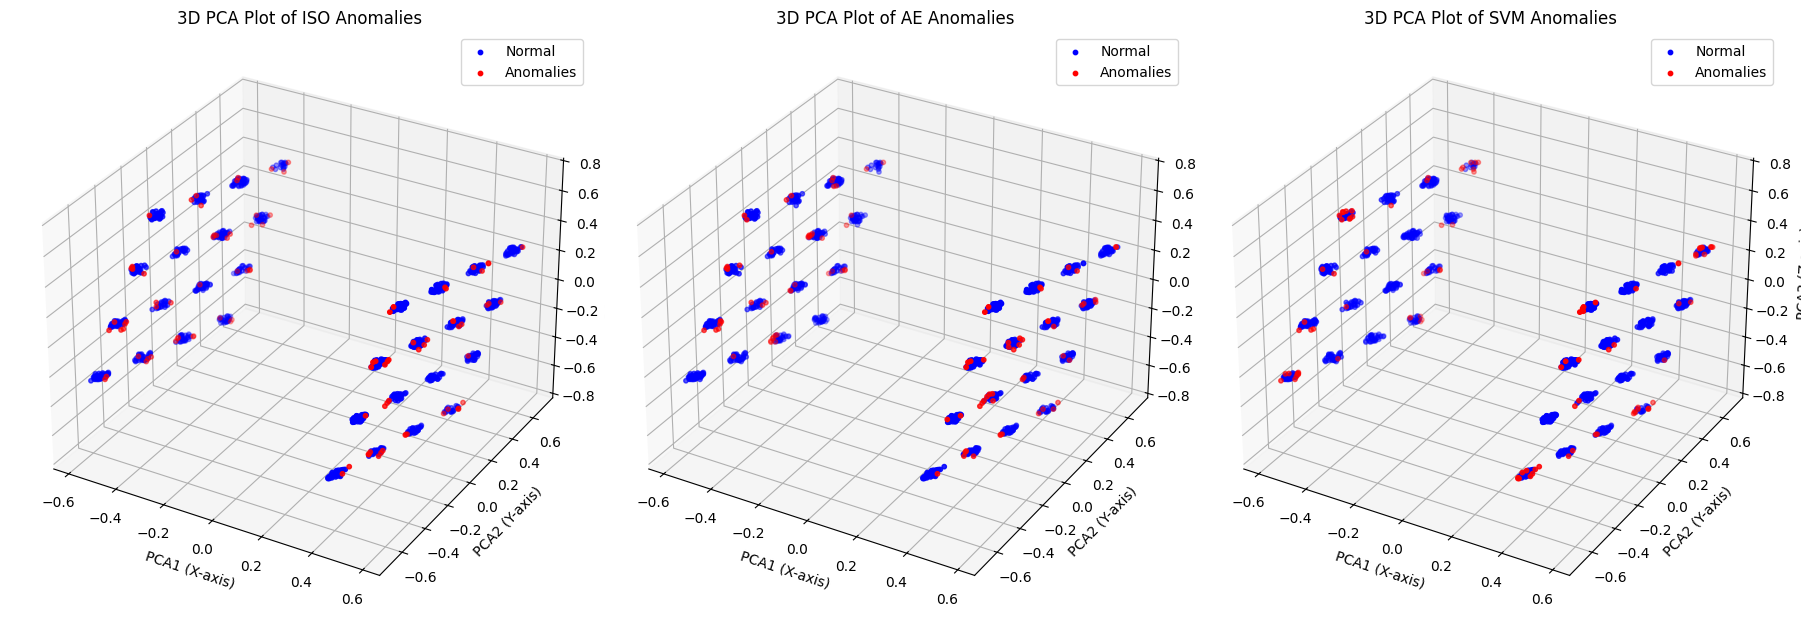

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to create 3D scatter plots for PCA results and anomalies
def plot_3d_pca_anomalies(data_pca_3d_df, anomaly_column, title, ax):
    # Separate normal points and anomalies
    normal_points = data_pca_3d_df[data_pca_3d_df[anomaly_column] == 0]
    anomaly_points = data_pca_3d_df[data_pca_3d_df[anomaly_column] == 1]
    
    # Create the 3D scatter plot
    ax.scatter(normal_points['PCA1'], normal_points['PCA2'], normal_points['PCA3'], 
               c='blue', label='Normal', s=10)
    ax.scatter(anomaly_points['PCA1'], anomaly_points['PCA2'], anomaly_points['PCA3'], 
               c='red', label='Anomalies', s=10)
    
    # Set axis labels
    ax.set_xlabel('PCA1 (X-axis)')
    ax.set_ylabel('PCA2 (Y-axis)')
    ax.set_zlabel('PCA3 (Z-axis)')
    
    # Set title and legend
    ax.set_title(title)
    ax.legend()

# Create a figure for 3D scatter plots with subplots
fig = plt.figure(figsize=(18, 8))

# Plot for Isolation Forest Anomalies
ax1 = fig.add_subplot(131, projection='3d')
plot_3d_pca_anomalies(data_pca_3d_df, 'Anomaly_ISO', '3D PCA Plot of ISO Anomalies', ax1)

# Plot for Autoencoder Anomalies
ax2 = fig.add_subplot(132, projection='3d')
plot_3d_pca_anomalies(data_pca_3d_df, 'Anomaly_AE', '3D PCA Plot of AE Anomalies', ax2)

# Plot for One-Class SVM Anomalies
ax3 = fig.add_subplot(133, projection='3d')
plot_3d_pca_anomalies(data_pca_3d_df, 'Anomaly_SVM', '3D PCA Plot of SVM Anomalies', ax3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [51]:
# Adding 3 columns to orignal dataframe
data['Anomaly_ISO'] = anomalies_iso
data['Anomaly_AE'] = anomalies_ae
data['Anomaly_SVM'] = anomalies_svm

In [52]:
data[data['Anomaly_AE']==0]

,TransactionID,Date,Amount,Commodity,Country,TradeVolume,TradeType,TransactionTime,Anomaly,Anomaly_ISO,Anomaly_AE,Anomaly_SVM
0,1,738521,10993.430,1,1,93.82,0,23.45,0,0,0,0
1,2,738522,9723.470,3,3,84.96,1,19.05,0,0,0,1
3,4,738524,13046.060,3,1,126.81,1,13.87,0,0,0,0
4,5,738525,9531.690,1,2,62.50,0,20.79,0,0,0,0
6,7,738527,13158.430,1,2,96.80,1,11.22,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,739516,9437.800,3,3,87.00,0,12.78,0,0,0,0
996,997,739517,13595.370,0,0,75.94,1,13.55,0,0,0,0
997,998,739518,11281.690,3,3,79.16,0,14.41,0,0,0,1
998,999,739519,885.764,0,0,902.60,1,0.00,1,1,0,1


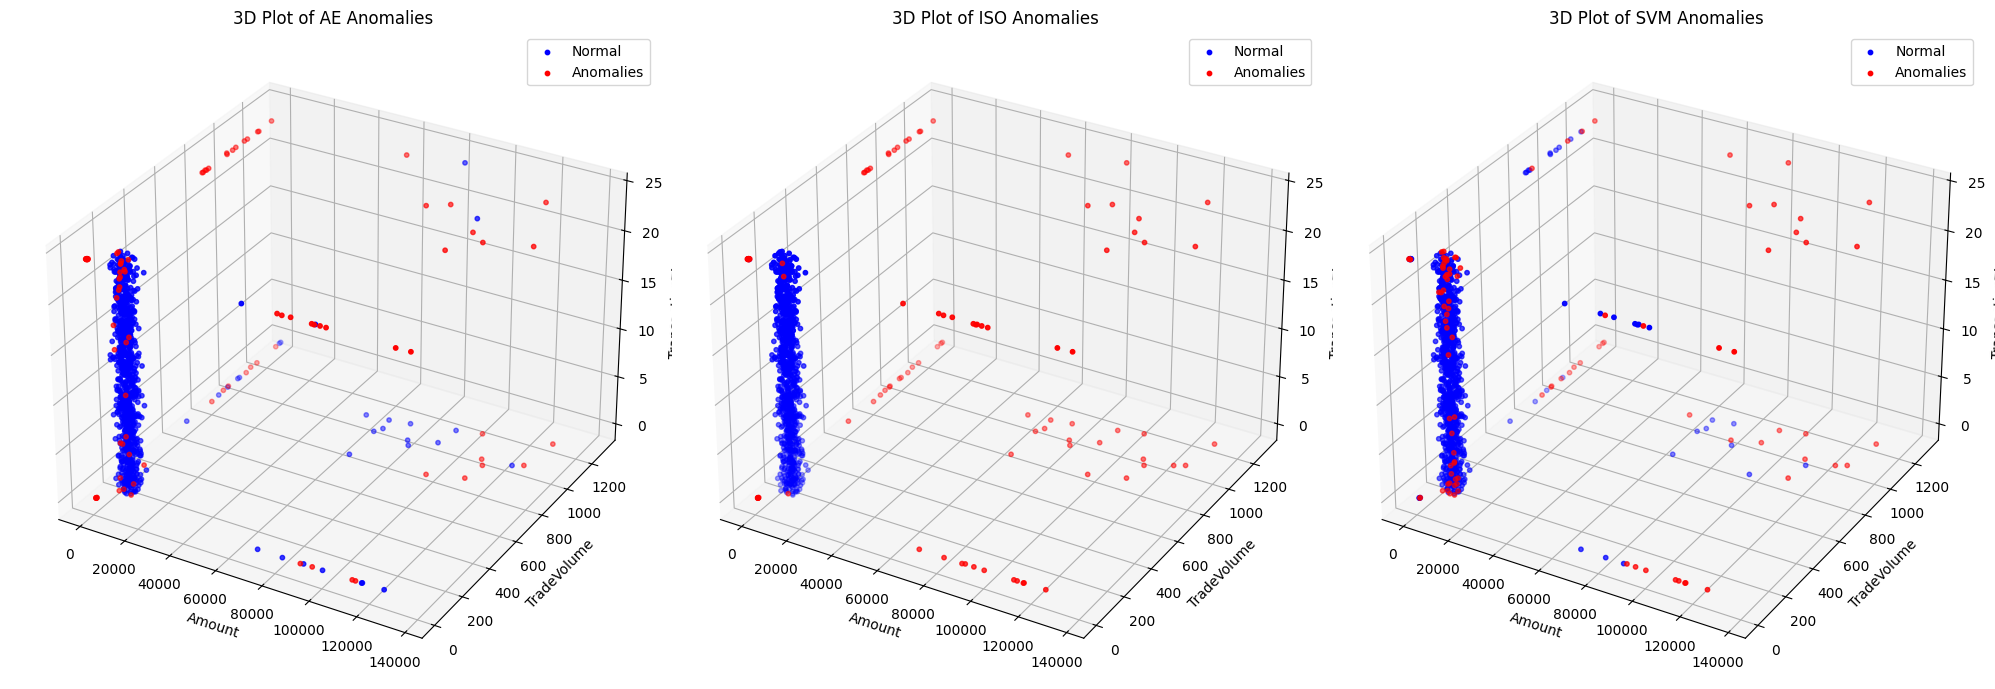

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# function to create 3d scatter plots for anomalies
def plot_3d_anomalies(data, anomaly_column, title, ax):
    # separate normal points and anomalies
    normal_points = data[data[anomaly_column] == 0]
    anomaly_points = data[data[anomaly_column] == 1]
    
    # 3d scatter plot
    ax.scatter(normal_points['Amount'], normal_points['TradeVolume'], normal_points['TransactionTime'], 
               c='blue', label='normal', s=10)
    ax.scatter(anomaly_points['Amount'], anomaly_points['TradeVolume'], anomaly_points['TransactionTime'], 
               c='red', label='anomalies', s=10)
    
    # set axis labels
    ax.set_xlabel('amount')
    ax.set_ylabel('tradevolume')
    ax.set_zlabel('transactiontime')
    
    # set title and legend
    ax.set_title(title)
    ax.legend()

# create a figure for 3d scatter plots
fig = plt.figure(figsize=(20, 16))

# plot for autoencoder anomalies (anomaly_ae)
ax1 = fig.add_subplot(131, projection='3d')
plot_3d_anomalies(data, 'Anomaly_AE', '3d plot of ae anomalies', ax1)

# plot for isolation forest anomalies (anomaly_iso)
ax2 = fig.add_subplot(132, projection='3d')
plot_3d_anomalies(data, 'Anomaly_ISO', '3d plot of iso anomalies', ax2)

# plot for one-class svm anomalies (anomaly_svm)
ax3 = fig.add_subplot(133, projection='3d')
plot_3d_anomalies(data, 'Anomaly_SVM', '3d plot of svm anomalies', ax3)

# show the plots
plt.tight_layout()
plt.show()
